<a href="https://colab.research.google.com/github/bhogasena/BikeSharingDemad/blob/main/Bike_Sharing_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bike Sharing Demand Prediction and Interpretation using Linear Regression

## Problem Statement

A bike-sharing system is a service in which bikes are made available for shared use to individuals on a short term basis for a price or free. Many bike share systems allow people to borrow a bike from a "dock" which is usually computer-controlled wherein the user enters the payment information, and the system unlocks it. This bike can then be returned to another dock belonging to the same system.

Compnay wants to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market.

The company wants to know:

*   Which variables are significant in predicting the demand for shared bikes.
*   How well those variables describe the bike demands




## Step 1: Reading and Understanding the Data

In [257]:
import numpy as np
import pandas as pd
import sklearn
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import scipy.sparse
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns=None


In [258]:
bike_df = pd.read_csv("day.csv")
bike_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [259]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


## Step 2: Visualising the Data

### Quantitative Continuous Variables Analysis using scatter plot

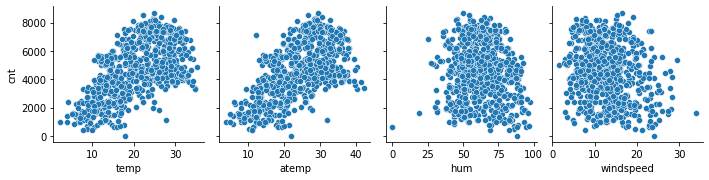

In [260]:
cont_vars = ['temp','atemp','hum','windspeed']
dep_vars=['cnt']
sns.pairplot(bike_df,x_vars=cont_vars,y_vars=dep_vars)
plt.show()

#### Observations

As per above plots, there seems to be linear relationship for temperature and feeling temperature with total rental bikes

In [261]:
desc_vars = ['season','yr','mnth','holiday','weekday','workingday','weathersit']
def create_box_plot(x_var,y_var,row,col,title,bins):
  tr1 = go.Histogram(x=bike_df[x_var],y=bike_df[y_var],histfunc='sum')
  tr1.update(name=title)
  fig.add_trace(tr1,row,col)
  fig.update_xaxes(title={
        'text': title},row=row,col=col)

fig = make_subplots(3,3,shared_yaxes=True)
create_box_plot('season','cnt',1,1,'Season',{'start':1,'end':4,'size':1})
create_box_plot('yr','cnt',1,2,'Year',{'start':0,'end':2,'size':1})
create_box_plot('mnth','cnt',1,3,'Month',{'start':1,'end':12,'size':1})
create_box_plot('holiday','cnt',2,1,'Holiday',{'start':0,'end':1,'size':1})
create_box_plot('weekday','cnt',2,2,'Weekday',{'start':0,'end':6,'size':1})
create_box_plot('workingday','cnt',2,3,'Workingday',{'start':0,'end':1,'size':1})
create_box_plot('weathersit','cnt',3,1,'Weathersit',{'start':1,'end':4,'size':1})

fig.update_layout(width=1200,height=1200,barmode='group', bargap=0.15)
fig.update_yaxes(title={'text':"Total Bikes Rented"},row=1,col=1)
fig.show()

#### Observations

*   Season3 has highest bike share rides followed by season2.
*   Seems bikes rentals increases year by year
*   May to September months have higher bike rentals compared to other months
*   Seems non-holidays have more bike rentals compared to holdiays.
*   There seems to be no significance difference on weekdays.
*   Working days have higher bike rentals.
*   Clear weather (weathersit:1) have higher bike rentals

## Step 3: Data Preparation

#### Data Cleaning

*   instant is unique id and so we can delete.
*   dteday as well can be deleted as we already have month and year in separate columns
*   As we are dealing with total bike shares, we can drop casual and registered columns as well.

In [262]:
bike_df.drop(['instant','dteday','casual','registered'],inplace=True,axis=1)
bike_df.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,4508.006849
std,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,1936.011647
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,5966.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,8714.000000


## Step 4: Splitting the Data into Training and Testing Sets

In [263]:
np.random.seed(1)
bike_train_df, bike_test_df = train_test_split(bike_df,train_size=0.7, test_size=0.3, random_state=100)


### Data Pre-Processing

1) Let's scale the continuous numerical variables using MinMaxScalar - scaling helps to converge the faster and also will not lead to mis-interpretations due to high magnitudes.

2) Use one-hot encode for categorical features.

We are using here ColumnTransformer pipeline to do this.

In [264]:
preprocess_pipeline = ColumnTransformer([
                              ("numerical",MinMaxScaler(),['temp','atemp','hum','windspeed','cnt']),
                              ("categorical",OneHotEncoder(drop='first'),['season','mnth','weathersit','weekday'])
],remainder='passthrough')
bike_train_ndarray = preprocess_pipeline.fit_transform(bike_train_df)

In [265]:
bike_train_df = pd.DataFrame(bike_train_ndarray,columns=preprocess_pipeline.get_feature_names_out())
bike_train_df

,numerical__temp,numerical__atemp,numerical__hum,numerical__windspeed,numerical__cnt,categorical__season_2,categorical__season_3,categorical__season_4,categorical__mnth_2,categorical__mnth_3,categorical__mnth_4,categorical__mnth_5,categorical__mnth_6,categorical__mnth_7,categorical__mnth_8,categorical__mnth_9,categorical__mnth_10,categorical__mnth_11,categorical__mnth_12,categorical__weathersit_2,categorical__weathersit_3,categorical__weekday_1,categorical__weekday_2,categorical__weekday_3,categorical__weekday_4,categorical__weekday_5,categorical__weekday_6,remainder__yr,remainder__holiday,remainder__workingday
0,0.509887,0.501133,0.575354,0.300794,0.864243,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.815169,0.766351,0.725633,0.264686,0.827658,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.442393,0.438975,0.640189,0.255342,0.465255,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.245101,0.200348,0.498067,0.663106,0.204096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.395666,0.391735,0.504508,0.188475,0.482973,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,0.824514,0.762183,0.605840,0.355596,0.764151,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
506,0.863973,0.824359,0.679690,0.187140,0.832835,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
507,0.202618,0.218747,0.435939,0.111379,0.218017,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
508,0.248216,0.223544,0.577930,0.431816,0.312586,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [266]:
bike_test_ndarray = preprocess_pipeline.transform(bike_test_df)
bike_test_df = pd.DataFrame(bike_test_ndarray,columns=preprocess_pipeline.get_feature_names_out())
bike_test_df

,numerical__temp,numerical__atemp,numerical__hum,numerical__windspeed,numerical__cnt,categorical__season_2,categorical__season_3,categorical__season_4,categorical__mnth_2,categorical__mnth_3,categorical__mnth_4,categorical__mnth_5,categorical__mnth_6,categorical__mnth_7,categorical__mnth_8,categorical__mnth_9,categorical__mnth_10,categorical__mnth_11,categorical__mnth_12,categorical__weathersit_2,categorical__weathersit_3,categorical__weekday_1,categorical__weekday_2,categorical__weekday_3,categorical__weekday_4,categorical__weekday_5,categorical__weekday_6,remainder__yr,remainder__holiday,remainder__workingday
0,0.831783,0.769660,0.657364,0.084219,0.692706,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.901354,0.842587,0.610133,0.153728,0.712034,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.511964,0.496145,0.837699,0.334206,0.303382,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.881625,0.795343,0.437098,0.339570,0.547400,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.817246,0.741471,0.314298,0.537414,0.569029,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,0.257562,0.243430,0.708888,0.287411,0.336516,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
215,0.519232,0.511907,0.756118,0.283397,0.757478,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
216,0.584649,0.577380,0.650923,0.069510,0.495973,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
217,0.745598,0.682653,0.817947,0.052115,0.868615,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [267]:
bike_train_df.columns = bike_train_df.columns.str.replace('numerical__','')
bike_train_df.columns = bike_train_df.columns.str.replace('categorical__','')
bike_train_df.columns = bike_train_df.columns.str.replace('remainder__','')
bike_test_df.columns = bike_test_df.columns.str.replace('numerical__','')
bike_test_df.columns = bike_test_df.columns.str.replace('categorical__','')
bike_test_df.columns = bike_test_df.columns.str.replace('remainder__','')


In [268]:
bike_test_df.columns

Index(['temp', 'atemp', 'hum', 'windspeed', 'cnt', 'season_2', 'season_3',
       'season_4', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7',
       'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'weathersit_2',
       'weathersit_3', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'yr', 'holiday', 'workingday'],
      dtype='object')

In [269]:
px.imshow(bike_train_df.corr(),text_auto=True,width=1200,height=1200,color_continuous_scale='greens')

#### Observations

*   Temperature and feeling temperature are highly correlated with correlation coefficient of 0.99
*   target variable 'cnt' has more correlation to 'atemp', 'yr', 'seanson3', 'month8' and 'month9'. As per my guess these should be highly significant variables. Let's see at end after our model build and evaluation.
*   As feeling tempeterature ('atemp')  is correlated with bike rentals we start with this variable first to build a model and drop the 'temp' feature.



In [270]:
bike_train_df.drop('temp',axis=1,inplace=True)

## Step 5: Building a linear model

### I am going to build model Manually and then using Automatic feature selection using RFE (Recursive Feature Elimination)

In [271]:
y_train = bike_train_df.pop('cnt')
X_train = bike_train_df
y_test = bike_test_df.pop('cnt')
X_test = bike_test_df
X_train_sk = X_train.copy()
y_train_sk = y_train.copy()

## Manual - Model 1

In [272]:
def linear_model(x_vars,df):
  X_train_lm = sm.add_constant(df[x_vars])
  model =  sm.OLS(y_train, X_train_lm).fit()
  print(model.summary())
  return model



#### Let's build a linear regression model with one variable 'atemp' first as this has high correlation with dependent variable 'cnt'

In [273]:
lr_atemp = linear_model(['atemp'],X_train)


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     364.7
Date:                Sat, 04 Jun 2022   Prob (F-statistic):           1.10e-61
Time:                        22:42:17   Log-Likelihood:                 176.51
No. Observations:                 510   AIC:                            -349.0
Df Residuals:                     508   BIC:                            -340.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1629      0.020      8.199      0.0

#### Observations.
As per model parameters, 'atemp' feature is significant to describe the target variable as it has P-value of 0.000. R-Squared is 0.418 means 41.8% os variance is output variable is described by the 'atemp' feature.


Let's add one more variable the second highest correlated feature 'yr' to  our next model

## Manual - Model 2

In [274]:
## Add one more variable 'yr'
lr3 = linear_model(['atemp','yr'],X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     579.5
Date:                Sat, 04 Jun 2022   Prob (F-statistic):          1.07e-131
Time:                        22:42:17   Log-Likelihood:                 341.87
No. Observations:                 510   AIC:                            -677.7
Df Residuals:                     507   BIC:                            -665.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0721      0.015      4.810      0.0

#### Observations

*   R2 increased from 0.418 to 0.696 which is significant improvement. We can see adjusted R-squared also increased at same rate.
*  This is in-line with our correlation matrix that second highest correlation feature to 'cnt' variable is 'yr'.

With these two features we can describe that the 69.6% variance in our target variable 'cnt' is contributed by 'atemp' and 'yr'

#### Let's add the third highest correlation variable 'season_3' for our next model

## Manual - Model 3

In [275]:
## Add one more variable 'season_3'
lr4 = linear_model(['atemp','yr','season_3'],X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     393.3
Date:                Sat, 04 Jun 2022   Prob (F-statistic):          8.89e-132
Time:                        22:42:17   Log-Likelihood:                 345.39
No. Observations:                 510   AIC:                            -682.8
Df Residuals:                     506   BIC:                            -665.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0525      0.017      3.158      0.0

#### Observations

*   There is no siginificant imrovement in our R2-score. I think it should be due to correlation with 'atemp' and 'season3'. 

#### Let's try to add all variables and then we drop one by one based on P-value and VIF

## Manual - Model 6

In [276]:
### Adding All variables to Model
lr_all = linear_model(X_train.columns,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     101.9
Date:                Sat, 04 Jun 2022   Prob (F-statistic):          4.12e-180
Time:                        22:42:17   Log-Likelihood:                 523.84
No. Observations:                 510   AIC:                            -991.7
Df Residuals:                     482   BIC:                            -873.1
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1754      0.031      5.729   

#### Observations

*  Weekday_4 has highest P value and so delete this feature and rebuild the model.



In [277]:
X_train.drop(['weekday_4'],axis=1,inplace=True)


## Manual - Model 7

In [278]:
lr_all = linear_model(X_train.columns,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     101.9
Date:                Sat, 04 Jun 2022   Prob (F-statistic):          4.12e-180
Time:                        22:42:17   Log-Likelihood:                 523.84
No. Observations:                 510   AIC:                            -991.7
Df Residuals:                     482   BIC:                            -873.1
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1754      0.031      5.729   

### Observations


*   There is no change in R2 even after we drop Weekday4. That means Weekday4 is not significance variable to describe the dependent variable 'cnt'
*   Drop next highest P-value feature 'Weekday_3'



## Manual - Model 8

In [279]:
X_train.drop(['weekday_3'],axis=1,inplace=True)
lr_all = linear_model(X_train.columns,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     106.0
Date:                Sat, 04 Jun 2022   Prob (F-statistic):          4.20e-181
Time:                        22:42:17   Log-Likelihood:                 523.78
No. Observations:                 510   AIC:                            -993.6
Df Residuals:                     483   BIC:                            -879.2
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1752      0.031      5.728   

#### Observations

*   R2- still same and F-Static got increased and that means overall model is good compared to previous model.
*   Drop the highest p-value column 'mnth_12'





## Manual - Model 9

In [280]:
X_train.drop(['mnth_12'],axis=1,inplace=True)
lr_all = linear_model(X_train.columns,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     110.3
Date:                Sat, 04 Jun 2022   Prob (F-statistic):          5.12e-182
Time:                        22:42:17   Log-Likelihood:                 523.50
No. Observations:                 510   AIC:                            -995.0
Df Residuals:                     484   BIC:                            -884.9
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1783      0.030      5.890   

Lets drop the variables one by one and rebuild model and keep delete until we have features which P-values are less than significance level 0.05

## Manual - Model 10

In [281]:
X_train.drop(['mnth_11'],axis=1,inplace=True) 
lr_all = linear_model(X_train.columns,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     115.1
Date:                Sat, 04 Jun 2022   Prob (F-statistic):          5.01e-183
Time:                        22:42:17   Log-Likelihood:                 523.44
No. Observations:                 510   AIC:                            -996.9
Df Residuals:                     485   BIC:                            -891.0
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1783      0.030      5.897   

## Manual - Model 11

In [282]:
X_train.drop(['weekday_5'],axis=1,inplace=True)
lr_all = linear_model(X_train.columns,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     120.2
Date:                Sat, 04 Jun 2022   Prob (F-statistic):          6.07e-184
Time:                        22:42:17   Log-Likelihood:                 523.13
No. Observations:                 510   AIC:                            -998.3
Df Residuals:                     486   BIC:                            -896.6
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1789      0.030      5.922   

## Manual - Model 12

In [283]:
X_train.drop(['holiday'],axis=1,inplace=True)
lr_all = linear_model(X_train.columns,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     125.7
Date:                Sat, 04 Jun 2022   Prob (F-statistic):          8.23e-185
Time:                        22:42:17   Log-Likelihood:                 522.67
No. Observations:                 510   AIC:                            -999.3
Df Residuals:                     487   BIC:                            -901.9
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1743      0.030      5.849   

## Manual - Model 13

In [284]:
X_train.drop(['mnth_7'],axis=1,inplace=True)
lr_all = linear_model(X_train.columns,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     131.5
Date:                Sat, 04 Jun 2022   Prob (F-statistic):          1.34e-185
Time:                        22:42:17   Log-Likelihood:                 522.00
No. Observations:                 510   AIC:                            -1000.
Df Residuals:                     488   BIC:                            -906.8
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1735      0.030      5.822   

## Manual - Model 14

In [285]:
X_train.drop(['weekday_2'],axis=1,inplace=True)
lr_all = linear_model(X_train.columns,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     137.8
Date:                Sat, 04 Jun 2022   Prob (F-statistic):          2.50e-186
Time:                        22:42:17   Log-Likelihood:                 521.16
No. Observations:                 510   AIC:                            -1000.
Df Residuals:                     489   BIC:                            -911.4
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1749      0.030      5.869   

## Manual - Model 15

In [286]:
X_train.drop(['mnth_2'],axis=1,inplace=True)
lr_all = linear_model(X_train.columns,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     144.9
Date:                Sat, 04 Jun 2022   Prob (F-statistic):          4.37e-187
Time:                        22:42:17   Log-Likelihood:                 520.36
No. Observations:                 510   AIC:                            -1001.
Df Residuals:                     490   BIC:                            -916.0
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1839      0.029      6.358   

## Manual - Model 16

In [287]:
X_train.drop(['mnth_4'],axis=1,inplace=True)
lr_all = linear_model(X_train.columns,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     152.2
Date:                Sat, 04 Jun 2022   Prob (F-statistic):          1.32e-187
Time:                        22:42:17   Log-Likelihood:                 518.97
No. Observations:                 510   AIC:                            -999.9
Df Residuals:                     491   BIC:                            -919.5
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1874      0.029      6.488   

## Manual - Model 17

In [288]:
X_train.drop(['mnth_6'],axis=1,inplace=True)
lr_all = linear_model(X_train.columns,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     160.4
Date:                Sat, 04 Jun 2022   Prob (F-statistic):          4.06e-188
Time:                        22:42:17   Log-Likelihood:                 517.53
No. Observations:                 510   AIC:                            -999.1
Df Residuals:                     492   BIC:                            -922.8
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1867      0.029      6.452   

## Manual - Model 18

In [289]:
X_train.drop(['weekday_1'],axis=1,inplace=True)
lr_all = linear_model(X_train.columns,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     169.5
Date:                Sat, 04 Jun 2022   Prob (F-statistic):          1.48e-188
Time:                        22:42:18   Log-Likelihood:                 515.89
No. Observations:                 510   AIC:                            -997.8
Df Residuals:                     493   BIC:                            -925.8
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1857      0.029      6.406   

#### Observations

*   Now all feature's p-values are less than significance level of 0.05. Let's calculate the VIF values now.


In [290]:
def get_vif(df):
  vif = pd.DataFrame()
  vif['features'] = df.columns
  vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
  vif['VIF'] = round(vif['VIF'], 2)
  vif = vif.sort_values(by = "VIF", ascending = False)
  print(vif)

In [291]:
get_vif(X_train)

        features    VIF
0          atemp  23.33
1            hum  17.42
4       season_3   8.22
15    workingday   4.60
2      windspeed   3.90
3       season_2   3.68
5       season_4   3.15
11  weathersit_2   2.14
14            yr   2.05
8         mnth_8   1.86
13     weekday_6   1.81
7         mnth_5   1.68
10       mnth_10   1.64
9         mnth_9   1.50
6         mnth_3   1.33
12  weathersit_3   1.20




1.   'atemp' has highest VIF but let's keep that as we saw almost 45% of variance in target can be descrived by this feature. This has highest VIF means this feature can be explained by other independent features in our model. Let's try to remove 'hum' feature.



## Manual - Model 21

In [292]:
X_train.drop(['hum'],axis=1,inplace=True)
lr_all = linear_model(X_train.columns,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     173.2
Date:                Sat, 04 Jun 2022   Prob (F-statistic):          1.31e-185
Time:                        22:42:18   Log-Likelihood:                 506.13
No. Observations:                 510   AIC:                            -980.3
Df Residuals:                     494   BIC:                            -912.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0894      0.019      4.639   

Let's drop 'mnth_5' now

## Manual - Model 22

In [293]:
X_train.drop(['mnth_5'],axis=1,inplace=True) 
lr_all = linear_model(X_train.columns,X_train)


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     185.0
Date:                Sat, 04 Jun 2022   Prob (F-statistic):          2.66e-186
Time:                        22:42:18   Log-Likelihood:                 505.06
No. Observations:                 510   AIC:                            -980.1
Df Residuals:                     495   BIC:                            -916.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0886      0.019      4.592   

In [294]:
get_vif(X_train)

        features    VIF
0          atemp  15.54
3       season_3   7.65
13    workingday   4.19
1      windspeed   3.60
2       season_2   3.39
4       season_4   2.98
12            yr   2.04
6         mnth_8   1.85
11     weekday_6   1.73
8        mnth_10   1.63
9   weathersit_2   1.54
7         mnth_9   1.49
5         mnth_3   1.28
10  weathersit_3   1.11


## Manual - Model 23

In [295]:
X_train.drop(['season_3'],axis=1,inplace=True) 
lr_all = linear_model(X_train.columns,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     194.5
Date:                Sat, 04 Jun 2022   Prob (F-statistic):          3.85e-185
Time:                        22:42:18   Log-Likelihood:                 499.55
No. Observations:                 510   AIC:                            -971.1
Df Residuals:                     496   BIC:                            -911.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0788      0.019      4.095   

## Manual - Model 24

In [296]:
X_train.drop(['mnth_3'],axis=1,inplace=True)  
lr_all = linear_model(X_train.columns,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     210.2
Date:                Sat, 04 Jun 2022   Prob (F-statistic):          6.63e-186
Time:                        22:42:18   Log-Likelihood:                 498.58
No. Observations:                 510   AIC:                            -971.2
Df Residuals:                     497   BIC:                            -916.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0828      0.019      4.346   

In [297]:
get_vif(X_train)

        features   VIF
0          atemp  6.18
11    workingday  4.09
1      windspeed  3.45
10            yr  2.02
3       season_4  2.00
2       season_2  1.83
9      weekday_6  1.70
6        mnth_10  1.61
4         mnth_8  1.55
7   weathersit_2  1.54
5         mnth_9  1.33
8   weathersit_3  1.10


## Manual - Model 25

In [298]:
X_train.drop(['mnth_10'],axis=1,inplace=True)  
lr_all = linear_model(X_train.columns,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     227.2
Date:                Sat, 04 Jun 2022   Prob (F-statistic):          4.54e-186
Time:                        22:42:18   Log-Likelihood:                 496.15
No. Observations:                 510   AIC:                            -968.3
Df Residuals:                     498   BIC:                            -917.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0782      0.019      4.117   

In [299]:
get_vif(X_train)

        features   VIF
0          atemp  6.02
10    workingday  4.06
1      windspeed  3.45
9             yr  2.02
2       season_2  1.82
8      weekday_6  1.69
4         mnth_8  1.55
6   weathersit_2  1.54
3       season_4  1.52
5         mnth_9  1.30
7   weathersit_3  1.08


# **Final Manual Model**

In [300]:
lr_manual_final = linear_model(X_train.columns,X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     227.2
Date:                Sat, 04 Jun 2022   Prob (F-statistic):          4.54e-186
Time:                        22:42:18   Log-Likelihood:                 496.15
No. Observations:                 510   AIC:                            -968.3
Df Residuals:                     498   BIC:                            -917.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0782      0.019      4.117   

#### Observations


1.   I think it should be our final model as we have all P-values 0.000 and also VIF <5.

R2 of our final model is 0.836 - which is good.

2.   Let's try to predict the y_train values and see Error terms.



## Step 6: Residual Analysis

In [301]:
X_train_pred = sm.add_constant(X_train)
y_train_pred = lr_manual_final.predict(X_train_pred)
res = y_train - y_train_pred

In [302]:
fig = px.histogram(data_frame=res,histnorm='probability')
fig.update_xaxes(title={'text':'Error Terms - (y_test - y_predicted)'})
fig.update_layout(title={'text':'Error Terms'})
fig.show()


#### Observations

*   Assumptions of Linear regression model is Error terms should be normally distributed and we saw that our model has almost mean of zero and normally distributed. 
*   And also there is no multicollinality as we have all features in final model <5 for VIF







In [303]:
px.scatter(x=y_train,y=y_train_pred)

## Step 7 : Model Evaluation

In [304]:
lr_manual_final.params.index

Index(['const', 'atemp', 'windspeed', 'season_2', 'season_4', 'mnth_8',
       'mnth_9', 'weathersit_2', 'weathersit_3', 'weekday_6', 'yr',
       'workingday'],
      dtype='object')

In [305]:
X_test_lm = sm.add_constant(X_test[X_train.columns])
y_test_pred = lr_manual_final.predict(X_test_lm)

In [306]:
r2 = r2_score(y_test, y_test_pred)
r2

0.7985406332345732

#### Observations


*   Our model has **R2-Score of 0.836** with train data and with **test data** predictions we got **0.804** which is good.




----------------------------------------------------------------------------------------------------------------------------------------------------------------

# Lets Try to Build model with RFE (Recursive Feature Eliminatin)

-------------------------------------------------------------------------------
-------------------------------------------------------------------------------

#### We have 11 independent variables in our final model which is built manually. Lets' start with 15 features 

In [307]:
sk_lr_model = LinearRegression()
rfe = RFE(sk_lr_model,n_features_to_select=15)
rfe = rfe.fit(X_train_sk, y_train_sk)

In [308]:
list(zip(X_train_sk.columns,rfe.support_,rfe.ranking_))

[('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_2', True, 1),
 ('season_3', True, 1),
 ('season_4', True, 1),
 ('mnth_2', False, 7),
 ('mnth_3', False, 3),
 ('mnth_4', False, 5),
 ('mnth_5', False, 2),
 ('mnth_6', False, 4),
 ('mnth_7', False, 6),
 ('mnth_8', True, 1),
 ('mnth_9', True, 1),
 ('mnth_10', True, 1),
 ('mnth_11', False, 8),
 ('mnth_12', False, 9),
 ('weathersit_2', True, 1),
 ('weathersit_3', True, 1),
 ('weekday_1', False, 10),
 ('weekday_2', False, 11),
 ('weekday_3', False, 13),
 ('weekday_4', False, 14),
 ('weekday_5', False, 12),
 ('weekday_6', True, 1),
 ('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1)]

In [309]:
sig_cols = X_train_sk.columns[rfe.support_]

## RFE - Model 1

In [310]:
X_train_sk = X_train_sk[sig_cols]
rfe_model1 = linear_model(sig_cols,X_train_sk)


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     179.5
Date:                Sat, 04 Jun 2022   Prob (F-statistic):          8.04e-189
Time:                        22:42:18   Log-Likelihood:                 513.81
No. Observations:                 510   AIC:                            -995.6
Df Residuals:                     494   BIC:                            -927.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1938      0.029      6.658   

In [311]:
get_vif(X_train_sk[sig_cols])

        features    VIF
0          atemp  22.71
1            hum  17.79
4       season_3   7.67
14    workingday   5.05
2      windspeed   3.85
3       season_2   3.37
5       season_4   2.88
9   weathersit_2   2.15
12            yr   2.04
11     weekday_6   1.91
6         mnth_8   1.86
8        mnth_10   1.64
7         mnth_9   1.51
10  weathersit_3   1.20
13       holiday   1.16


#### Drop the **Month_5** as which has P-value > 0.05



In [312]:
X_train_sk.drop('Month_5',axis=1,inplace=True)

KeyError: ignored

## RFE - Model 2

In [ ]:
rfe_model2 = linear_model(X_train_sk.columns,X_train_sk)

In [ ]:
get_vif(X_train_sk)

#### Drop the **Month_3** as which has P-value > 0.05

In [ ]:
X_train_sk.drop('Month_3',axis=1,inplace=True)

## RFE - Model 3

In [ ]:
rfe_model3 = linear_model(X_train_sk.columns,X_train_sk)

In [ ]:
get_vif(X_train_sk)

#### Drop the **holiday** as which has P-value > 0.05

In [ ]:
X_train_sk.drop('holiday',axis=1,inplace=True)

## RFE - Model 4

In [ ]:
rfe_model4 = linear_model(X_train_sk.columns,X_train_sk)

In [ ]:
get_vif(X_train_sk)

#### We now have all independent variables P-vales less than Significance level of 0.05 but 'hum' has high VIF of 11.64.

Let's try to drop the 'hum' and observe the R2 score and F-static

In [ ]:
X_train_sk.drop('hum',axis=1,inplace=True)

## RFE - Model 5

In [ ]:
rfe_model5 = linear_model(X_train_sk.columns,X_train_sk)

In [ ]:
get_vif(X_train_sk)

#### Drop the **Month_10** as which has P-value > 0.05

In [ ]:
X_train_sk.drop('Month_10',axis=1,inplace=True)

## RFE - Model 6

In [ ]:
rfe_model6 = linear_model(X_train_sk.columns,X_train_sk)

In [ ]:
get_vif(X_train_sk)

#### Drop the **Month_8** as which has P-value almost at significance level

In [ ]:
X_train_sk.drop('Month_8',axis=1,inplace=True)

## RFE - Model 7

In [ ]:
rfe_model7 = linear_model(X_train_sk.columns,X_train_sk)

In [ ]:
get_vif(X_train_sk)

#### This should be our good fit model as all p-values are zero and also VIF <5 (i.e, no multicollinearity)

In [ ]:
rfe_final_model = linear_model(X_train_sk.columns,X_train_sk)

In [ ]:
X_test = X_test[X_train_sk.columns]


In [ ]:
X_test_lm = sm.add_constant(X_test)
y_pred = rfe_final_model.predict(X_test_lm)

In [ ]:
r2 = r2_score(y_test,y_pred)
r2

In [ ]:
fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred')              
plt.xlabel('y_test')                         
plt.ylabel('y_pred') 
plt.show()

#### Observations


*   Our final model using RFE has **R2-Score of 0.807** with train data and with test data predictions we got **0.772**. 
    F-statistic:                     232.8, 
    Prob (F-statistic):          1.59e-172
*   Our final model using manual elimination  has **R2-Score of 0.836** with train data and with test data predictions we got **0.796**.
F-statistic:                     254.0
Prob (F-statistic):          1.47e-188

#### It seems our manual model is good compared to RFE one.

## Final Observations


*   As per our manual feature elimination model, below are the top3 significant variables with their coefficients to predict the bike share rides count.
           

1.   temp             :   0.5499
2.   weathersit_3       :         -0.2880
3.   yr          :        0.2331


*   Our model has **R2-Score** of **0.836** with train data and with **test data** predictions we got **0.796** which is good.
*   Error terms are almost normally distrbuted with mean 0- this is one of the assumption for linear regression model
*  There is no multicollinearity in our model as VIFs are less than 5.
### Intepretations



1.   A unit increase in temp variable casues the bike share rides count increase by 0.5499 units
2. A unit increase in yr variable casues the bike share rides count increase by 0.2331 units
3. A unit increase in weathersit3(Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds variable casues the bike share rides count decrease by 0.2880 units



